# How to train an ontology-based variational autoencoder (Ontix)

In normal autoencoders latent dimensions are not explainable by design. To gain explainability and to incorporate biological information, a popular approach is to restrict the decoder of the autoencoder to match feature connectivity like an ontology. 

In this notebook we will show two types of ontologies and how they can be used to train an explainable variational autoencoder `ontix`. 
The first is based on biological pathways of the Reactome database (left) and the second uses chromosomal location of genes (right) as a showcase. 

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/5dabc4a697cbba74d3f6144dc4b6d0fd6df2b624/images/ontix_scheme.svg" alt="ontix-ontologies" width="1200"/>

## Set-up your ontology

The only thing you need to do to train an `ontix` is to provide text files for up to two ontology levels. The first ontology level is the mapping of your features (e.g. Gene ID) and an ontology level like subpathways or cytobands of chromosome. The second level is optional, but recommended, and is the mapping of the first ontology to a second level like top-level pathways or chromosome. 

The mapping should have the format:  
Gene 1 `separator` Pathway1  
Gene 2 `separator` Pathway1  
Gene 3 `separator` Pathway2  
..

By default the `separator` is defined as tabular via `DELIM:"\t"` in the `src/000_internal_config.yaml`

### Example 1: Set-up chromosomal ontology
From Ensembl via Biomart or any other sequence database you can get cytoband (karyotype) and chromosomal information for human genes like this:

In [1]:
import pandas as pd

df_genes = pd.read_csv("genes_chromosomes.txt", sep="\t" )
df_genes

,Gene stable ID,Gene stable ID version,Karyotype band,Chromosome/scaffold name,Gene start (bp),Gene end (bp),HGNC symbol,NCBI gene (formerly Entrezgene) ID
0,ENSG00000198888,ENSG00000198888.2,NaN,MT,3307,4262,MT-ND1,4535
1,ENSG00000198763,ENSG00000198763.3,NaN,MT,4470,5511,MT-ND2,4536
2,ENSG00000198804,ENSG00000198804.2,NaN,MT,5904,7445,MT-CO1,4512
3,ENSG00000210151,ENSG00000210151.2,NaN,MT,7446,7514,MT-TS1,113219467
4,ENSG00000198712,ENSG00000198712.1,NaN,MT,7586,8269,MT-CO2,4513
...,...,...,...,...,...,...,...,...
35852,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,102725121
35853,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,100287596
35854,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,100287102
35855,ENSG00000290825,ENSG00000290825.1,p36.33,1,11869,14409,NaN,727856


We have to solve some issues before we can use this as ontology.  
(1) We only want chromosomes and not scaffolds  
(2) Karyotype/cytoband should have identification of the chromosome in their name as identifier

In [2]:
df_genes = df_genes.loc[ df_genes['Chromosome/scaffold name'].str.len() < 3] ## get rid of scaffolds and keep only chromosomes
df_genes.loc[df_genes['Chromosome/scaffold name'] == "MT", 'Karyotype band'] = 'MT' ## create missing karyotype for mito genes
print("This will be our chromosomes and latent dimensions in Ontix:")
print(df_genes['Chromosome/scaffold name'].unique())
print(f"Latent dimension: {len(df_genes['Chromosome/scaffold name'].unique())}")

This will be our chromosomes and latent dimensions in Ontix:
['MT' 'Y' '21' '13' '18' '22' '20' 'X' '15' '14' '10' '9' '8' '16' '4' '5'
 '7' '6' '19' '12' '11' '3' '17' '2' '1']
Latent dimension: 25


In [4]:
# Combine Chromosome name and cytoband
df_genes.loc[:,'Chr_and_karyotype'] = df_genes.loc[:,['Chromosome/scaffold name','Karyotype band']].apply(lambda x: ':'.join(x.values.tolist()), axis=1)
print("This will be our hidden layer in the sparse decoder:")
print(df_genes['Chr_and_karyotype'].unique()[0:20])
print(f"Hidden layer dim: {len(df_genes['Chr_and_karyotype'].unique())}")

This will be our hidden layer in the sparse decoder:
['MT:MT' 'Y:p11.2' 'Y:q11.223' 'Y:q11.221' 'Y:q11.222' 'Y:q11.23'
 'Y:p11.31' 'Y:p11.32' 'Y:q12' '21:p12' '21:q21.1' '21:q21.2' '21:p11.2'
 '13:q12.12' '21:q21.3' '21:q22.11' '13:q12.3' '13:q14.12' '13:q14.2'
 '21:q22.12']
Hidden layer dim: 817


Now we can save this as files in the correct format for the two levels

In [5]:
# Level 1
df_genes[
	['NCBI gene (formerly Entrezgene) ID','Chr_and_karyotype']	# Level 1: Feature (gene) to hidden layer (cytoband)
	].drop_duplicates(											# Chromosomal ontology must be unique
	).to_csv(
		"../data/raw/chromosome_ont_lvl1_ncbi.txt",				# Save under data/raw
		sep="\t",
		header=False,
		index=False )	

# Level 2
df_genes[
	['Chr_and_karyotype','Chromosome/scaffold name']			# Level 2: hidden layer (cytoband) to latent dimension (chromosome)
	].drop_duplicates(											# Chromosomal ontology must be unique
	).to_csv(
		"../data/raw/chromosome_ont_lvl2.txt",				# Save under data/raw
		sep="\t",
		header=False,
		index=False )	

## Create your config 
This is very much similar to a normal VAE `varix` as shown in the `Basics_Autoencodix.ipynb` tutorial. With the following adjustments and additions:  
(1) set `MODEL_TYPE` to `ontix`  
(2) specify ontologies files under `FILE_ONT_LVL1` and `FILE_ONT_LVL1`  
(3) specify number of layers after ontology layers in the decoder. We set this to `NON_ONT_LAYER:0` since we want no additional dimension reduction by additional layers upon the ontology.

In [ ]:
## We will use Python for config defintion, but you can write your own yaml-config with an editor
import yaml
cfg = dict()
# Ontix specific
cfg['MODEL_TYPE'] = "ontix" 
cfg['FILE_ONT_LVL1'] = "chromosome_ont_lvl1_ncbi.txt"
cfg['FILE_ONT_LVL2'] = "chromosome_ont_lvl2.txt"
cfg['NON_ONT_LAYER'] = 0

# DATA DEFINITIONS ------------------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DATA_TYPE'] = dict()
# RNAseq
cfg['DATA_TYPE']['RNA'] = dict()
cfg['DATA_TYPE']['RNA']['SCALING'] = "Standard"	# We scale features by the standard scaler
cfg['DATA_TYPE']['RNA']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['RNA']['FILTERING'] = "Var"	# We filter for feature with highest variance
cfg['DATA_TYPE']['RNA']['FILE_RAW'] = "combined_rnaseq_formatted.parquet"

# METH
cfg['DATA_TYPE']['METH'] = dict()
cfg['DATA_TYPE']['METH']['SCALING'] = "Standard"
cfg['DATA_TYPE']['METH']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['METH']['FILTERING'] = "Var"
cfg['DATA_TYPE']['METH']['FILE_RAW'] = "combined_meth_formatted.parquet"

# Clinical Parameters for plotting
cfg['DATA_TYPE']['ANNO'] = dict()
cfg['DATA_TYPE']['ANNO']['TYPE'] = "ANNOTATION"
cfg['DATA_TYPE']['ANNO']['FILE_RAW'] = "combined_clin_formatted.parquet"

## Model and Training --------------------------------------------------------
# ----------------------------------------------------------------------------
# Reproducibility
cfg['FIX_RANDOMNESS'] = "all"
cfg['GLOBAL_SEED'] = 42
# Model
cfg['TRAIN_TYPE'] = "train" # simple training, no tuning
cfg['RECONSTR_LOSS'] = "MSE"	# loss function for reconstruction
cfg['VAE_LOSS'] = "KL"		# loss function distribution distance
cfg['BETA'] = 0.5			# weighting of VAE loss
cfg['K_FILTER'] = 1000		# Input features per data modality
cfg["LATENT_DIM_FIXED"] = 6	# Latent space dimension
# Training
cfg['EPOCHS'] = 500
cfg['LR_FIXED'] = 0.0005	# Learning rate
cfg['BATCH_SIZE'] = 128
cfg['DROP_P'] = 0.3			# We have a small number of samples and should be aggressive with drop out to avoid overfitting
# Prediction
cfg['PREDICT_SPLIT'] = "all"	# Embedding of all samples should be calculated in prediction
# EVALUATION and VISUALIZATION ------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DIM_RED_METH'] = "UMAP"	# For 2D visualization when LATENT_DIM_FIXED>2
cfg['CLINIC_PARAM'] = [			# Parameters to colorize plots and perform embedding evaluation
				"CANCER_TYPE",
				"CANCER_TYPE_ACRONYM",
				"TMB_NONSYNONYMOUS",
				"AGE",
				"OS_STATUS",
				"GRADE",
				"SEX"
			]
cfg['ML_TYPE'] = "Auto-detect"	# Is CLINIC_PARAM prediction either regression or classification?
cfg['ML_ALG'] = [				# ML algorithms for embedding evaluation
	'Linear',
	'RF'
	]
cfg['ML_SPLIT'] = "use-split"	# Test ML performance on train, test, valid split
cfg['ML_TASKS'] = [				# Compare embeddings to other dimension reduction methods
	'Latent',
	'UMAP',
	'PCA',
	'RandomFeature'
]


## save config
with open("../"+"TCGA-Chr-Ontix_config.yaml", 'w') as file:
	yaml.dump(cfg, file)

## Train and visualize the `ontix`


In [2]:
# Make sure to start from project root folder
%cd .. 
# Activate venv
!source venv-gallia/bin/activate
# Setting CUBLAS for reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:16:8
# Start pipeline
!make visualize RUN_ID=TCGA-Chr-Ontix

/home/ewald/Github/autoencodix
env: CUBLAS_WORKSPACE_CONFIG=:16:8
done config
2025-04-11 11:11:02,817 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2025-04-11 11:11:04,850 - src.utils.utils_basic - INFO - Save sample split.
2025-04-11 11:11:04,862 - src.utils.utils_basic - INFO - Unified sample ID list has length 3529
2025-04-11 11:11:04,863 - src.utils.utils_basic - INFO - Make data set ANNO
2025-04-11 11:11:04,871 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2025-04-11 11:11:04,892 - src.utils.utils_basic - INFO - Make data set METH
2025-04-11 11:11:05,601 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2025-04-11 11:11:05,758 - src.utils.utils_basic - INFO - Preprocessing of ontology files
2025-04-11 11:11:06,385 - src.utils.utils_basic - WARNING - Number of features not in ontology file: 44
2025-04-11 11:11:06,396 - src.utils.utils_basic - WARNING - Dropping features not in ontology.
2025-04-11 11:11:06

### Gaining insights by explainable latent dimensions and visualizations
The idea behind chromosomal location of features (genes) as an ontology for `ontix` that we can expect male and female patients to be separated on the `Y` and `X` chromosome.  
Let`s have a look if this is the case:  

Latent intensitiy plot grouped by  female/male patients


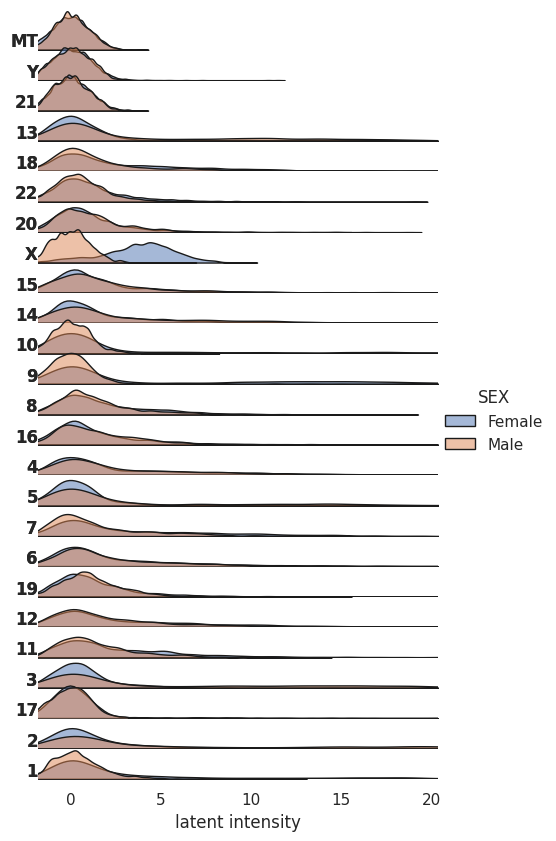

In [3]:
from IPython.display import Image
from IPython.display import display

ridgeline_chr = Image(filename='reports/TCGA-Chr-Ontix/figures/latent_dist_SEX.png', width=600)

print("Latent intensitiy plot grouped by  female/male patients")
display(ridgeline_chr)

Indeed it is for the `X` chromosome. However, not for the `Y`.  
This is related to the fact that it is much smaller than other chromosomes and very few genes are located on `Y`.  
Hence, those genes and latent dimension has only very little impact on minimizing the loss function and a potential signal is not visible. 

### Prior-knowledge can improve embeddings
We see that chromosome-based VAE embeddings cleary distinct female and male samples. Let's check the embeddings on several classification and regression tasks.

In [4]:
# Evaluate embeddings
!make ml_task_only RUN_ID=TCGA-Chr-Ontix

done config
2025-04-11 11:16:10,829 - src.utils.utils_basic - INFO - Performing predictive power evaluation
2025-04-11 11:16:10,830 - src.utils.utils_basic - INFO - Perform ML task with feature df: Latent
2025-04-11 11:16:10,907 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE
2025-04-11 11:16:13,015 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE_ACRONYM
2025-04-11 11:16:15,286 - src.utils.utils_basic - INFO - Perform ML task for target parameter: TMB_NONSYNONYMOUS
2025-04-11 11:16:15,287 - src.utils.utils_basic - WARNING - There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
2025-04-11 11:16:17,397 - src.utils.utils_basic - INFO - Perform ML task for target parameter: AGE
2025-04-11 11:16:19,328 - src.utils.utils_basic - INFO - Perform ML task for target parameter: SEX
2025-04-11 11:16:20,485 - src.utils.utils_basic - INFO - Perform ML task for target paramete

Make a comparison as well to a normal VAE which is trained in the previous Tutorial `Basics_Autoencodix.ipynb` and we see that for female/male classification we gain a significantly better embedding by incorporating prior-knowledge.

In [5]:
import pandas as pd
print("Female/male classification with logistic regression")
# Performance of Ontix
df_ml_ontix = pd.read_csv("./reports/TCGA-Chr-Ontix/ml_task_performance.txt", sep="\t")
ontix_latent = (df_ml_ontix.CLINIC_PARAM == "SEX") & (df_ml_ontix.ML_ALG == "Linear") & (df_ml_ontix.ML_TASK == "Latent") & (df_ml_ontix.score_split == "test")
print("Performance of ontix:")
print("ROC_AUC: " + df_ml_ontix.loc[ontix_latent,"value"].to_string(index=False))

# Performance with PCA
ontix_pca = (df_ml_ontix.CLINIC_PARAM == "SEX") & (df_ml_ontix.ML_ALG == "Linear") & (df_ml_ontix.ML_TASK == "PCA") & (df_ml_ontix.score_split == "test")
print("Performance of PCA:")
print("ROC_AUC: " + df_ml_ontix.loc[ontix_pca,"value"].to_string(index=False))

# Performance with UMAP
ontix_umap = (df_ml_ontix.CLINIC_PARAM == "SEX") & (df_ml_ontix.ML_ALG == "Linear") & (df_ml_ontix.ML_TASK == "PCA") & (df_ml_ontix.score_split == "test")
print("Performance of UMAP:")
print("ROC_AUC: " + df_ml_ontix.loc[ontix_umap,"value"].to_string(index=False))

# Performance with Random Features
ontix_randfeat = (df_ml_ontix.CLINIC_PARAM == "SEX") & (df_ml_ontix.ML_ALG == "Linear") & (df_ml_ontix.ML_TASK == "RandomFeature") & (df_ml_ontix.score_split == "test")

# Make Average
print("Performance of Random Features:")
print("ROC_AUC: " + str(df_ml_ontix.loc[ontix_randfeat,"value"].mean()))

# Performance from Tutorial Basics_Autoencodix
df_ml_varix = pd.read_csv("./reports/TCGA-Example/ml_task_performance.txt", sep="\t")
varix_latent = (df_ml_varix.CLINIC_PARAM == "SEX") & (df_ml_varix.ML_ALG == "Linear") & (df_ml_varix.ML_TASK == "Latent") & (df_ml_varix.score_split == "test")
print("Performance of varix:")
print("ROC_AUC: " + df_ml_varix.loc[varix_latent,"value"].to_string(index=False))

Female/male classification with logistic regression
Performance of ontix:
ROC_AUC: 0.993091
Performance of PCA:
ROC_AUC: 0.958702
Performance of UMAP:
ROC_AUC: 0.958702
Performance of Random Features:
ROC_AUC: 0.7470322319820648
Performance of varix:
ROC_AUC: 0.940792


## Using Reactome pathways as ontology
Chromosomal location as ontology is mostly a proof of concept as shown above how to gain explainability of latent dimensions.  
In practice, something like biological pathways or gene ontology is most commonly used to gain biological insights. 

### Get the reactome ontology and adjust the config

In [6]:
# %cd .. 
## We provide already pre-formatted files 
!echo "Level 1 file"
!head ./Tutorials/full_ont_lvl1_reactome.txt

!echo "Level 2 file"
!head ./Tutorials/full_ont_lvl2_reactome_named.txt
## Copy to data/raw
!cp ./Tutorials/lvl*.txt data/raw/


Level 1 file
1	R-HSA-168249
100049587	R-HSA-168249
10006	R-HSA-168249
10006	R-HSA-168249
10010	R-HSA-168249
100132285	R-HSA-168249
100133267	R-HSA-168249
100289462	R-HSA-168249
100293534	R-HSA-168249
100302736	R-HSA-168249
Level 2 file
R-HSA-140837	Hemostasis
R-HSA-418346	Hemostasis
R-HSA-392851	Hemostasis
R-HSA-76005	Hemostasis
R-HSA-210993	Hemostasis
R-HSA-983189	Hemostasis
R-HSA-76002	Hemostasis
R-HSA-983231	Hemostasis
R-HSA-114604	Hemostasis
R-HSA-210990	Hemostasis


In [7]:
## We copy the previous config as template
!cp TCGA-Chr-Ontix_config.yaml TCGA-Rea-Ontix_config.yaml

## Change the ontology files to Reactome pathways in the copied config
!sed -i "s/FILE_ONT_LVL1\: chromosome_ont_lvl1_ncbi.txt/FILE_ONT_LVL1\: full_ont_lvl1_reactome.txt/g " TCGA-Rea-Ontix_config.yaml
!sed -i "s/FILE_ONT_LVL2\: chromosome_ont_lvl2.txt/FILE_ONT_LVL2\: full_ont_lvl2_reactome_named.txt/g " TCGA-Rea-Ontix_config.yaml

## Train and visualize the Reactome-based `ontix`

In [8]:
# Setting CUBLAS for reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:16:8

!make visualize RUN_ID=TCGA-Rea-Ontix

env: CUBLAS_WORKSPACE_CONFIG=:16:8
done config
2025-04-11 11:20:36,938 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2025-04-11 11:20:39,146 - src.utils.utils_basic - INFO - Save sample split.
2025-04-11 11:20:39,152 - src.utils.utils_basic - INFO - Unified sample ID list has length 3529
2025-04-11 11:20:39,153 - src.utils.utils_basic - INFO - Make data set ANNO
2025-04-11 11:20:39,160 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2025-04-11 11:20:39,182 - src.utils.utils_basic - INFO - Make data set METH
2025-04-11 11:20:39,912 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2025-04-11 11:20:40,120 - src.utils.utils_basic - INFO - Preprocessing of ontology files
2025-04-11 11:20:43,033 - src.utils.utils_basic - WARNING - Number of features not in ontology file: 3573
2025-04-11 11:20:43,035 - src.utils.utils_basic - WARNING - Dropping features not in ontology.
2025-04-11 11:20:43,075 - src.utils.utils_basic 

In [9]:
# Evaluate embeddings
!make ml_task_only RUN_ID=TCGA-Rea-Ontix

done config
2025-04-11 11:25:23,298 - src.utils.utils_basic - INFO - Performing predictive power evaluation
2025-04-11 11:25:23,299 - src.utils.utils_basic - INFO - Perform ML task with feature df: Latent
2025-04-11 11:25:23,347 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE
2025-04-11 11:25:24,704 - src.utils.utils_basic - INFO - Perform ML task for target parameter: CANCER_TYPE_ACRONYM
2025-04-11 11:25:26,371 - src.utils.utils_basic - INFO - Perform ML task for target parameter: TMB_NONSYNONYMOUS
2025-04-11 11:25:26,372 - src.utils.utils_basic - WARNING - There are NA values in the annotation file. Samples with missing data will be removed for ML task evaluation.
2025-04-11 11:25:28,052 - src.utils.utils_basic - INFO - Perform ML task for target parameter: AGE
2025-04-11 11:25:29,582 - src.utils.utils_basic - INFO - Perform ML task for target parameter: SEX
2025-04-11 11:25:30,582 - src.utils.utils_basic - INFO - Perform ML task for target paramete

Now we can check which Reactome top-level pathways (latent dimensions) are associated with clinical parameters.  
Let's start with male/female again. 

Latent intensitiy plot grouped by  female/male patients


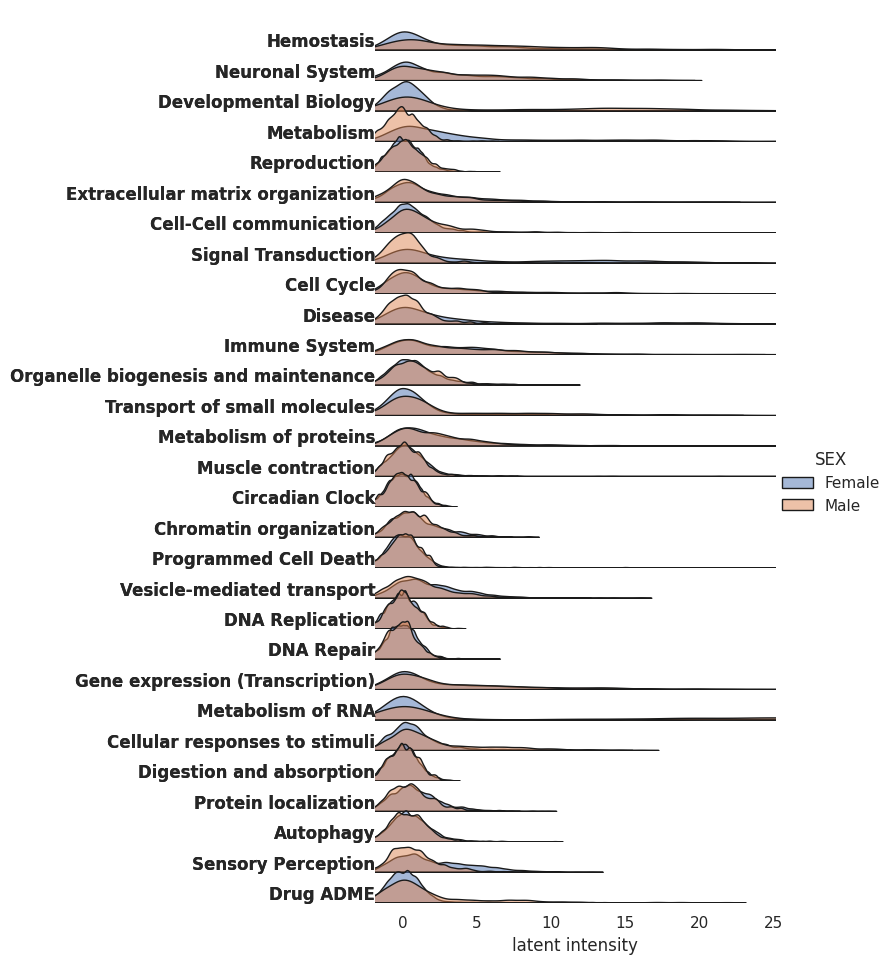

In [12]:
ridgeline_rea1 = Image(filename='reports/TCGA-Rea-Ontix/figures/latent_dist_SEX.png', width=600)

print("Latent intensitiy plot grouped by  female/male patients")
display(ridgeline_rea1)

We see that multiple biological pathways are not that strongly associated with differences in male/female samples as the chromosomal embedding. This shows that we need the right ontology to match our biological question.  
Let's have a look how our cancer subtypes associated with pathways?

Latent intensitiy plot grouped by cancer subtype


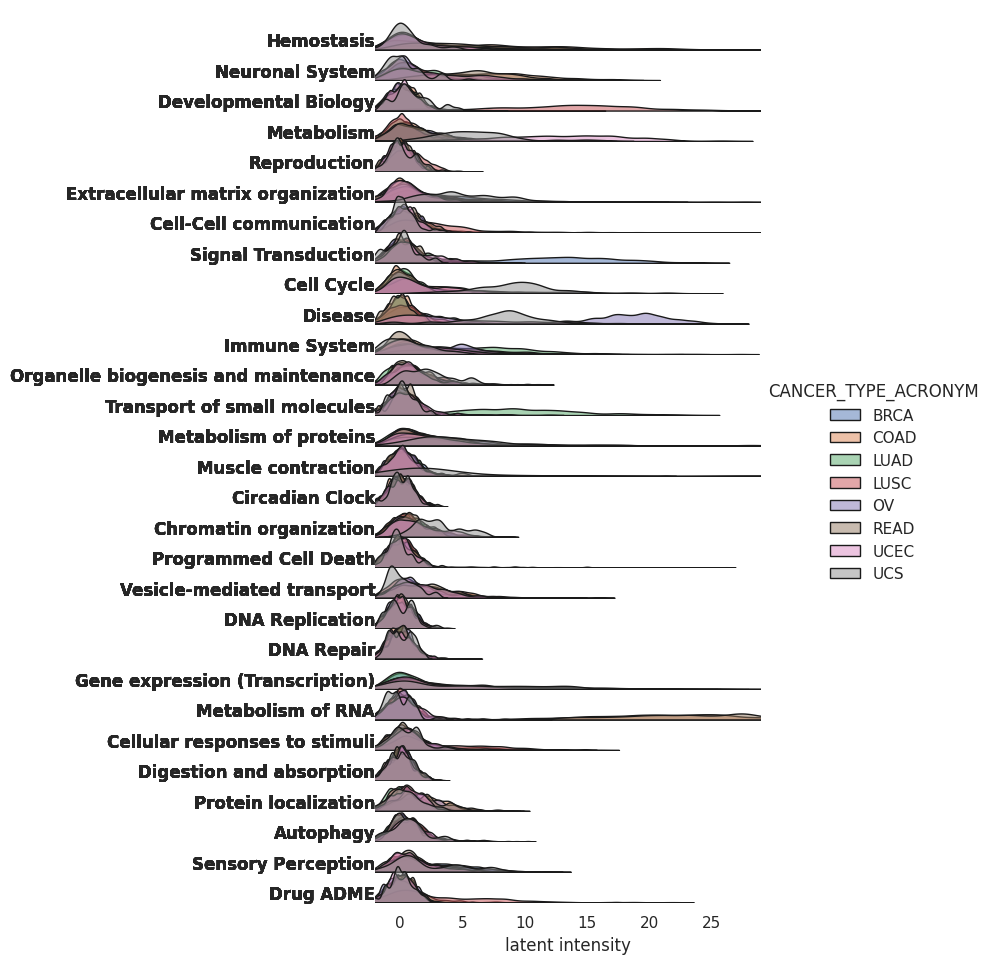

In [14]:
ridgeline_rea2 = Image(filename='reports/TCGA-Rea-Ontix/figures/latent_dist_CANCER_TYPE_ACRONYM.png', width=800)

print("Latent intensitiy plot grouped by cancer subtype")
display(ridgeline_rea2)

We can make some interesting observations like `LUAD` is distinct in the top-level pathway `Transport of small molecules` or `UCEC`+`UCS` show separation in `Metabolism`. 

It shows that depending on the ontology one can gain additional insights into clustering of subtypes with regard to biological functions and ontologies. 